In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os


print(tf.__version__)   # Tensorflow의 버전을 출력

mnist = keras.datasets.mnist

# MNIST 데이터를 로드. 다운로드하지 않았다면 다운로드까지 자동으로 진행됩니다. 
(x_train, y_train), (x_test, y_test) = mnist.load_data()   

print(len(x_train))  # x_train 배열의 크기를 출력

2.6.0
11501568/11490434 [==============================] - 0s 0us/step
60000


# GoingDeeper-Vol.2

## 2-6. Ablation Study 실습 (4) VGG-16 vs VGG-19

### VGG-16 모델을 만들고 훈련

In [14]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [25]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

###  정규화(normalize)

In [29]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [33]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [16]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [17]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


In [18]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [19]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [37]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [20]:
BATCH_SIZE = 256
EPOCH = 15

In [34]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [35]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 37s 128ms/step - loss: 2.1653 - accuracy: 0.1991 - val_loss: 2.0451 - val_accuracy: 0.2578
Epoch 2/15
195/195 [==============================] - 23s 119ms/step - loss: 1.9830 - accuracy: 0.2803 - val_loss: 1.9034 - val_accuracy: 0.3216
Epoch 3/15
195/195 [==============================] - 23s 120ms/step - loss: 1.8585 - accuracy: 0.3329 - val_loss: 1.8005 - val_accuracy: 0.3638
Epoch 4/15
195/195 [==============================] - 23s 118ms/step - loss: 1.7451 - accuracy: 0.3730 - val_loss: 1.7009 - val_accuracy: 0.3780
Epoch 5/15
195/195 [==============================] - 23s 117ms/step - loss: 1.6656 - accuracy: 0.3990 - val_loss: 1.5897 - val_accuracy: 0.4156
Epoch 6/15
195/195 [==============================] - 23s 118ms/step - loss: 1.6018 - accuracy: 0.4230 - val_loss: 1.5732 - val_accuracy: 0.4310
Epoch 7/15
195/195 [==============================] - 23s 118ms/step - loss: 1.5495 - accuracy: 0.4409 - val_loss: 1.5449 - val_ac

### *기존 학습치_2nd(비교)

In [23]:
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/15
195/195 [==============================] - 67s 125ms/step - loss: 2.1811 - accuracy: 0.1958 - val_loss: 2.0539 - val_accuracy: 0.2650
Epoch 2/15
195/195 [==============================] - 24s 126ms/step - loss: 1.9794 - accuracy: 0.2834 - val_loss: 1.8958 - val_accuracy: 0.3190
Epoch 3/15
195/195 [==============================] - 23s 120ms/step - loss: 1.8466 - accuracy: 0.3387 - val_loss: 1.8524 - val_accuracy: 0.3240
Epoch 4/15
195/195 [==============================] - 23s 120ms/step - loss: 1.7601 - accuracy: 0.3704 - val_loss: 1.6863 - val_accuracy: 0.4029
Epoch 5/15
195/195 [==============================] - 23s 119ms/step - loss: 1.6730 - accuracy: 0.4008 - val_loss: 1.6496 - val_accuracy: 0.4088
Epoch 6/15
195/195 [==============================] - 23s 119ms/step - loss: 1.6094 - accuracy: 0.4218 - val_loss: 1.5820 - val_accuracy: 0.4368
Epoch 7/15
195/195 [==============================] - 23s 120ms/step - loss: 1.5611 - accuracy: 0.4420 - val_loss: 1.5577 - val_accuracy: 0.4370
Epoch 8/15
195/195 [==============================] - 23s 119ms/step - loss: 1.5163 - accuracy: 0.4573 - val_loss: 1.4865 - val_accuracy: 0.4660
Epoch 9/15
195/195 [==============================] - 23s 120ms/step - loss: 1.4726 - accuracy: 0.4737 - val_loss: 1.4392 - val_accuracy: 0.4954
Epoch 10/15
195/195 [==============================] - 23s 119ms/step - loss: 1.4345 - accuracy: 0.4868 - val_loss: 1.3987 - val_accuracy: 0.5005
Epoch 11/15
195/195 [==============================] - 23s 119ms/step - loss: 1.3917 - accuracy: 0.5009 - val_loss: 1.4323 - val_accuracy: 0.4903
Epoch 12/15
195/195 [==============================] - 23s 119ms/step - loss: 1.3536 - accuracy: 0.5170 - val_loss: 1.3758 - val_accuracy: 0.5080
Epoch 13/15
195/195 [==============================] - 23s 119ms/step - loss: 1.3173 - accuracy: 0.5281 - val_loss: 1.3259 - val_accuracy: 0.5344
Epoch 14/15
195/195 [==============================] - 23s 119ms/step - loss: 1.2888 - accuracy: 0.5409 - val_loss: 1.3055 - val_accuracy: 0.5309
Epoch 15/15
195/195 [==============================] - 23s 120ms/step - loss: 1.2487 - accuracy: 0.5549 - val_loss: 1.3063 - val_accuracy: 0.5213

SyntaxError: invalid syntax (1269331340.py, line 1)

### VGG-19 모델을 만들고 훈련

In [38]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 31s 136ms/step - loss: 2.2480 - accuracy: 0.1512 - val_loss: 2.1663 - val_accuracy: 0.1954
Epoch 2/15
195/195 [==============================] - 27s 138ms/step - loss: 2.0662 - accuracy: 0.2376 - val_loss: 1.9965 - val_accuracy: 0.2703
Epoch 3/15
195/195 [==============================] - 27s 140ms/step - loss: 1.9314 - accuracy: 0.2952 - val_loss: 1.8561 - val_accuracy: 0.3210
Epoch 4/15
195/195 [==============================] - 27s 138ms/step - loss: 1.8173 - accuracy: 0.3395 - val_loss: 1.7287 - val_accuracy: 0.3897
Epoch 5/15
195/195 [==============================] - 27s 139ms/step - loss: 1.7026 - accuracy: 0.3819 - val_loss: 1.6636 - val_accuracy: 0.3935
Epoch 6/15
195/195 [==============================] - 27s 139ms/step - loss: 1.6383 - accuracy: 0.4073 - val_loss: 1.5960 - val_accuracy: 0.4301
Epoch 7/15
195/195 [==============================] - 27s 138ms/step - loss: 1.5803 - accuracy: 0.4272 - val_loss: 1.5217 - val_ac

### *기존 학습치_2nd(비교)

In [ ]:
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/15
195/195 [==============================] - 32s 139ms/step - loss: 2.2252 - accuracy: 0.1680 - val_loss: 2.1379 - val_accuracy: 0.2101
Epoch 2/15
195/195 [==============================] - 27s 141ms/step - loss: 2.0489 - accuracy: 0.2524 - val_loss: 1.9553 - val_accuracy: 0.2772
Epoch 3/15
195/195 [==============================] - 27s 141ms/step - loss: 1.8997 - accuracy: 0.3101 - val_loss: 1.8418 - val_accuracy: 0.3357
Epoch 4/15
195/195 [==============================] - 27s 140ms/step - loss: 1.7771 - accuracy: 0.3565 - val_loss: 1.7453 - val_accuracy: 0.3849
Epoch 5/15
195/195 [==============================] - 27s 140ms/step - loss: 1.6872 - accuracy: 0.3900 - val_loss: 1.6294 - val_accuracy: 0.4229
Epoch 6/15
195/195 [==============================] - 27s 140ms/step - loss: 1.6189 - accuracy: 0.4133 - val_loss: 1.5954 - val_accuracy: 0.4242
Epoch 7/15
195/195 [==============================] - 27s 141ms/step - loss: 1.5608 - accuracy: 0.4408 - val_loss: 1.5117 - val_accuracy: 0.4650
Epoch 8/15
195/195 [==============================] - 27s 140ms/step - loss: 1.5211 - accuracy: 0.4524 - val_loss: 1.5181 - val_accuracy: 0.4540
Epoch 9/15
195/195 [==============================] - 27s 140ms/step - loss: 1.4704 - accuracy: 0.4710 - val_loss: 1.4213 - val_accuracy: 0.4923
Epoch 10/15
195/195 [==============================] - 27s 141ms/step - loss: 1.4281 - accuracy: 0.4860 - val_loss: 1.3703 - val_accuracy: 0.5011
Epoch 11/15
195/195 [==============================] - 27s 140ms/step - loss: 1.3849 - accuracy: 0.5019 - val_loss: 1.3926 - val_accuracy: 0.5043
Epoch 12/15
195/195 [==============================] - 27s 140ms/step - loss: 1.3433 - accuracy: 0.5171 - val_loss: 1.3303 - val_accuracy: 0.5185
Epoch 13/15
195/195 [==============================] - 27s 141ms/step - loss: 1.3121 - accuracy: 0.5275 - val_loss: 1.3638 - val_accuracy: 0.5038
Epoch 14/15
195/195 [==============================] - 27s 140ms/step - loss: 1.2813 - accuracy: 0.5399 - val_loss: 1.2964 - val_accuracy: 0.5397
Epoch 15/15
195/195 [==============================] - 27s 140ms/step - loss: 1.2400 - accuracy: 0.5577 - val_loss: 1.2675 - val_accuracy: 0.5424

### 훈련 손실(training loss)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

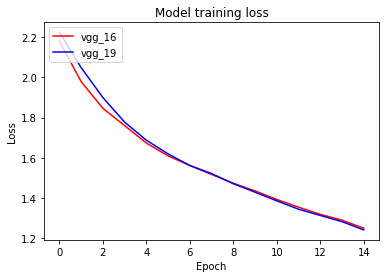

### 검증 정확도(validation accuracy)

In [ ]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

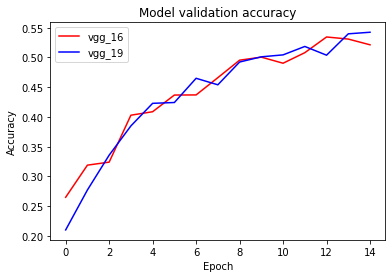